In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import catboost
from catboost import *
from region_entropy import find_optimal_region, sum_in_region
from region_visualizer import visualizer, create_bar_chart
from bucketing import compute_region

In [16]:
file_path = './data/diabetes.csv'
df = pd.read_csv(file_path)

X = df.drop(columns=['Outcome'])
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
cat_features_indices = [1]
cat_features_indices = []
model = CatBoostClassifier(iterations=500, learning_rate=0.1, random_seed=12, cat_features=cat_features_indices, depth=6, l2_leaf_reg=3)
model.fit(X_train, y_train, verbose=False, plot=False)
# dfの['Predicted']列に予測結果を代入する
df['Predicted'] = model.predict(X)

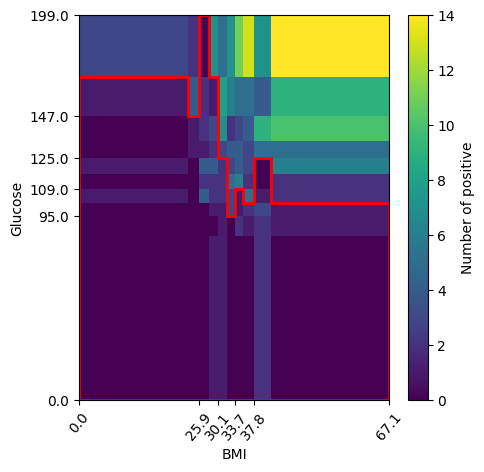

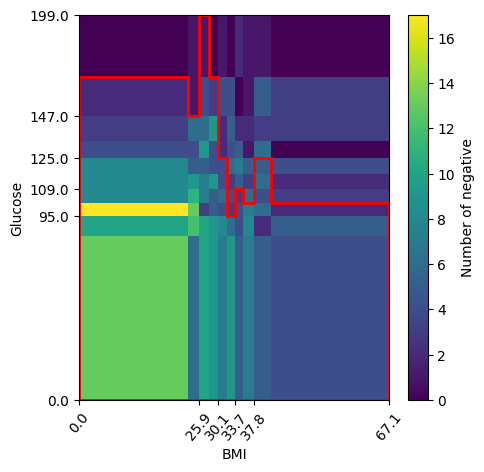

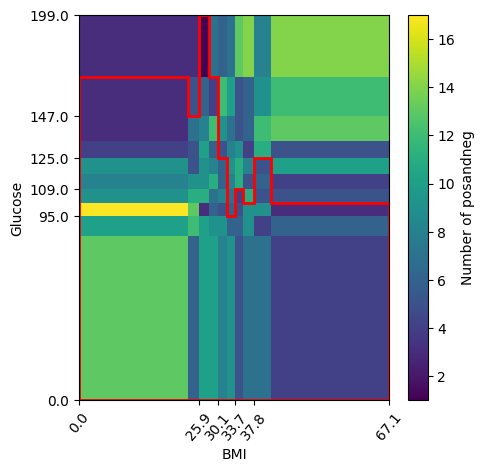

In [11]:
column_x, column_y = "Glucose", "BMI"
_, region, v, xbins, ybins, positive, negative, posandneg, x_bucket_num, y_bucket_num = compute_region(df, column_x, column_y)

points = positive
barlabel = "positive"
visualizer(
    points,
    region.bot,
    region.top,
    region.l,
    region.r,
    y_bucket_num,
    x_bucket_num,
    column_y,
    column_x,
    barlabel,
    ybins,
    xbins,
)

points = negative
barlabel = "negative"
visualizer(
    points,
    region.bot,
    region.top,
    region.l,
    region.r,
    y_bucket_num,
    x_bucket_num,
    column_y,
    column_x,
    barlabel,
    ybins,
    xbins,
)

visualizer(
    posandneg,
    region.bot,
    region.top,
    region.l,
    region.r,
    y_bucket_num,
    x_bucket_num,
    column_y,
    column_x,
    'posandneg',
    ybins,
    xbins,
)


In [12]:
# 全ての組み合わせを試す
check = True
#checkがTrueならこの処理を行う
if check:
    column_list = [
        "Pregnancies",
        "Glucose",
        "BloodPressure",
        "SkinThickness",
        "Insulin",
        "BMI",
        "DiabetesPedigreeFunction",
        "Age",
    ]
    v_list = []
    for i in range(len(column_list)):
        for j in range(len(column_list)):
            if i == j:
                continue
            column_x = column_list[i]
            column_y = column_list[j]
            x_bucket_num = 10
            y_bucket_num = 10
            _, region, v, xbins, ybins, positive, negative, posandneg, x_bucket_num, y_bucket_num = compute_region(df, column_x, column_y)
            v_list.append((column_x, column_y, v))

    v_list.sort(key=lambda x: x[2])
    print(v_list[:10])

[('Age', 'Glucose', 0.5029535214291367), ('Glucose', 'BMI', 0.5036939475294773), ('Glucose', 'Age', 0.5060425071309936), ('BMI', 'Glucose', 0.5108154117066779), ('Glucose', 'BloodPressure', 0.5244859518792953), ('Glucose', 'DiabetesPedigreeFunction', 0.5284700621746403), ('Pregnancies', 'Glucose', 0.5297935398397564), ('Glucose', 'Pregnancies', 0.5297935398397564), ('BloodPressure', 'Glucose', 0.5348022074668575), ('DiabetesPedigreeFunction', 'Glucose', 0.5348048819344404)]


In [13]:
# 多値分類タスクの場合は、positiveを特定のクラス、negativeをそれ以外のクラスとして扱う


## 説明が必要な特徴量ペアの検出

In [27]:
explain_index = 3 #0は陽性
# v_listの中で最もエントロピーが小さい組み合わせから順に調べていく
for column_x, column_y, _ in v_list[0:5]:
    print(column_x, column_y)
    df_with_bins, region, v, xbins, ybins, positive, negative, posandneg, x_bucket_num, y_bucket_num = compute_region(df, column_x, column_y)
    instance_to_explain = df_with_bins.iloc[explain_index]

    point, v, region = find_optimal_region(positive, negative)
    # instance_to_explainがどのバケツに入るかを調べる
    x_bucket_index = sorted(df_with_bins["x_Bin"].unique().tolist()).index(instance_to_explain["x_Bin"])
    y_bucket_index = sorted(df_with_bins["y_Bin"].unique().tolist()).index(instance_to_explain["y_Bin"])

    # region.bot[x] <= y <= region.top[x], region.l <= x <= region.rならinstance_to_explainはregionに入る
    original_in_or_out = region.l <= x_bucket_index <= region.r and\
        region.bot[x_bucket_index] <= y_bucket_index <= region.top[x_bucket_index]
    # x,yを変動させた時に領域の境界を超えるかどうかを調べる
    x_crossed = False
    for i in range(x_bucket_num):
        pertubated_in_or_out = region.l <= i <= region.r and\
              region.bot[i] <= y_bucket_index <= region.top[i]
        print("x:", i)
        if original_in_or_out != pertubated_in_or_out:
            x_crossed = True
            break
    y_crossed = False
    for i in range(y_bucket_num):
        pertubated_in_or_out = region.l <= x_bucket_index <= region.r and region.bot[x_bucket_index] <= i <= region.top[x_bucket_index]
        print("y:", i)
        if original_in_or_out != pertubated_in_or_out:
            y_crossed = True
            break
    need_explanation = x_crossed and y_crossed
    print('x_ind', x_bucket_index, 'y_ind', y_bucket_index)
    print(need_explanation)

Age Glucose
x: 0
x: 1
x: 2
x: 3
x: 4
x: 5
x: 6
x: 7
x: 8
x: 9
y: 0
y: 1
y: 2
y: 3
y: 4
y: 5
y: 6
y: 7
y: 8
y: 9
x_ind 0 y_ind 1
False
Glucose BMI
x: 0
x: 1
x: 2
x: 3
x: 4
x: 5
y: 0
y: 1
y: 2
y: 3
y: 4
y: 5
y: 6
y: 7
y: 8
x_ind 1 y_ind 2
True
Glucose Age
x: 0
x: 1
x: 2
x: 3
x: 4
x: 5
x: 6
x: 7
x: 8
x: 9
y: 0
y: 1
y: 2
y: 3
y: 4
y: 5
y: 6
y: 7
y: 8
y: 9
x_ind 1 y_ind 0
False
BMI Glucose
x: 0
x: 1
x: 2
x: 3
x: 4
x: 5
x: 6
x: 7
x: 8
y: 0
y: 1
y: 2
y: 3
y: 4
y: 5
x_ind 2 y_ind 1
True
Glucose BloodPressure
x: 0
x: 1
x: 2
x: 3
x: 4
x: 5
x: 6
x: 7
x: 8
x: 9
y: 0
y: 1
y: 2
y: 3
y: 4
y: 5
y: 6
y: 7
y: 8
y: 9
x_ind 1 y_ind 3
False


## 説明するインスタンスのハイライト

Pregnancies                            1
Glucose                               89
BloodPressure                         66
SkinThickness                         23
Insulin                               94
BMI                                 28.1
DiabetesPedigreeFunction           0.167
Age                                   21
Outcome                                0
Predicted                              0
x_Bin                       (85.0, 95.0]
y_Bin                       (64.0, 68.0]
Name: 3, dtype: object
1 3


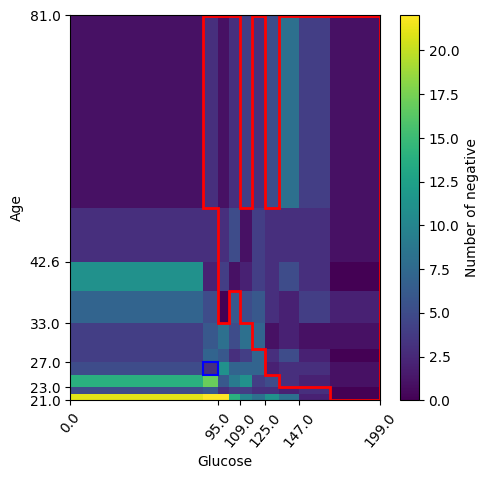

In [28]:
# ハイライト
column_x, column_y = "Age","Glucose"
objective_column = "Predicted"
df_with_bins, region, v, xbins, ybins, positive, negative, posandneg, x_bucket_num, y_bucket_num = compute_region(df, column_x, column_y)
print(instance_to_explain)
print(x_bucket_index, y_bucket_index)
instance_to_explain = df_with_bins.iloc[explain_index]
points = positive if instance_to_explain[objective_column] == 1 else negative

xbins, ybins = [round(num, 1) for num in xbins], [round(num, 1) for num in ybins]
visualizer(
    points,
    region.bot,
    region.top,
    region.l,
    region.r,
    y_bucket_num,
    x_bucket_num,
    column_y,
    column_x,
    barlabel,
    ybins,
    xbins,
    highlight=True,
    highlight_x=x_bucket_index,
    highlight_y=y_bucket_index,
)